In [2]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client

c = Client()
c

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:43194 Dashboard: http://127.0.0.1:35381/status,Cluster Workers: 8 Cores: 48 Memory: 134.91 GB


## Librairies and customization

In [3]:
import xarray as xr 
import dask 
import numpy as np 
import os 
import time 
import glob
from datetime import date
today=date.today()

import sys
sys.path.insert(0,'/home/albert7a/git/xscale')
import xscale

import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum
import xscale.signal.generator as xgen

import matplotlib.pyplot as plt
params = {'figure.figsize' : (15, 8),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [4]:
%time ds=xr.open_zarr('/store/albert7a/eNATL60/zarr/eNATL60-BLBT02-SSH-1h')
ds

CPU times: user 296 ms, sys: 125 ms, total: 421 ms
Wall time: 1.48 s


<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 11688, x: 8354, y: 4729)
Coordinates:
    time_centered         (time_counter) datetime64[ns] dask.array<shape=(11688,), chunksize=(240,)>
  * time_counter          (time_counter) datetime64[ns] 2010-01-19T00:30:00 ... 2009-09-17T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    nav_lat               (y, x) float32 dask.array<shape=(4729, 8354), chunksize=(240, 480)>
    nav_lon               (y, x) float32 dask.array<shape=(4729, 8354), chunksize=(240, 480)>
    sossheig              (time_counter, y, x) float32 dask.array<shape=(11688, 4729, 8354), chunksize=(240, 240, 480)>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(11688, 2), chunksize=(240, 2)>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(11688, 2), chunksize=(240, 2)>
Attributes:
    Conventions:  CF-1.6
    TimeStamp:    24/03/2019 14:43:2

In [5]:
ds_sorted=ds.sortby('time_counter')

In [6]:
print(ds.nbytes/1e9)

1847.304207184


In [7]:
ssh_FMA=ds_sorted.sel(time_counter=slice('2010-02-01','2010-04-30'))['sossheig']

In [8]:
ssh_ASO=ds_sorted.sel(time_counter=slice('2009-08-01','2009-10-31'))['sossheig']

In [9]:
def compute_plot_spectrum_ssh_reg(size):
    ssh_FMA_reg=ssh_FMA[:,2000:2000+size,4000:4000+size]
    ssh_ASO_reg=ssh_ASO[:,2000:2000+size,4000:4000+size]
    NPADDING = 2
    SPtime_FMA_reg = xfft.fft(ssh_FMA_reg, dim='time_counter', dx=1., detrend='mean',nfft=ssh_FMA_reg.shape[0]*NPADDING,tapering=True)
    SPtime_ASO_reg = xfft.fft(ssh_ASO_reg, dim='time_counter', dx=1., detrend='mean',nfft=ssh_ASO_reg.shape[0]*NPADDING,tapering=True)
    MEANPSD_FMA=xfft.psd(SPtime_FMA_reg).mean(dim='x').mean(dim='y').load()
    MEANPSD_ASO=xfft.psd(SPtime_ASO_reg).mean(dim='x').mean(dim='y').load()
    freqs_FMA=MEANPSD_FMA.f_time_counter.values
    freqs_FMA = freqs_FMA[NPADDING::] 
    freqs_ASO=MEANPSD_ASO.f_time_counter.values
    freqs_ASO = freqs_ASO[NPADDING::] 

    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.loglog(freqs_FMA,MEANPSD_FMA[NPADDING::],'k',label='winter')
    ax.loglog(freqs_ASO,MEANPSD_ASO[NPADDING::],'r',label='summer')
    ax.set_xlim(1e-3,1)
    ax.grid(which='both',axis='both')
    plt.xlabel('Frequency (cpd)')
    plt.ylabel('PSD (m2/cpd)')
    plt.legend()
    plt.title('Temporal Spectrum of SSH in the box of size '+str(size)+' x '+str(size))

In [10]:
def compute_plot_spectrum_ssh_reg_dask(size,chunksize):
    ssh_FMA_reg=ssh_FMA[:,2000:2000+size,4000:4000+size].chunk({'x':chunksize,'y':chunksize})
    ssh_ASO_reg=ssh_ASO[:,2000:2000+size,4000:4000+size].chunk({'x':chunksize,'y':chunksize})
    NPADDING = 2
    SPtime_FMA_reg = xfft.fft(ssh_FMA_reg, dim='time_counter', dx=1., detrend='mean',nfft=ssh_FMA_reg.shape[0]*NPADDING,tapering=True)
    SPtime_ASO_reg = xfft.fft(ssh_ASO_reg, dim='time_counter', dx=1., detrend='mean',nfft=ssh_ASO_reg.shape[0]*NPADDING,tapering=True)
    MEANPSD_FMA=xfft.psd(SPtime_FMA_reg).mean(dim='x').mean(dim='y').load()
    MEANPSD_ASO=xfft.psd(SPtime_ASO_reg).mean(dim='x').mean(dim='y').load()
    freqs_FMA=MEANPSD_FMA.f_time_counter.values
    freqs_FMA = freqs_FMA[NPADDING::] 
    freqs_ASO=MEANPSD_ASO.f_time_counter.values
    freqs_ASO = freqs_ASO[NPADDING::] 

    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.loglog(freqs_FMA,MEANPSD_FMA[NPADDING::],'k',label='winter')
    ax.loglog(freqs_ASO,MEANPSD_ASO[NPADDING::],'r',label='summer')
    ax.set_xlim(1e-3,1)
    ax.grid(which='both',axis='both')
    plt.xlabel('Frequency (cpd)')
    plt.ylabel('PSD (m2/cpd)')
    plt.legend()
    plt.title('Temporal Spectrum of SSH in the box of size '+str(size)+' x '+str(size))

CPU times: user 12.5 s, sys: 6.21 s, total: 18.7 s
Wall time: 54.3 s


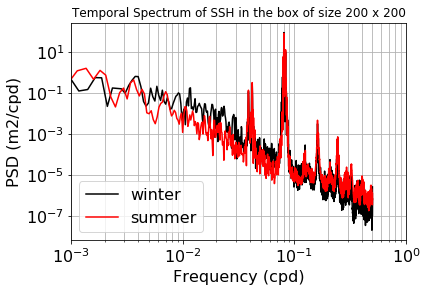

In [13]:
%time compute_plot_spectrum_ssh_reg(200) # 1x1

CPU times: user 29.3 s, sys: 17.8 s, total: 47.1 s
Wall time: 2min 51s


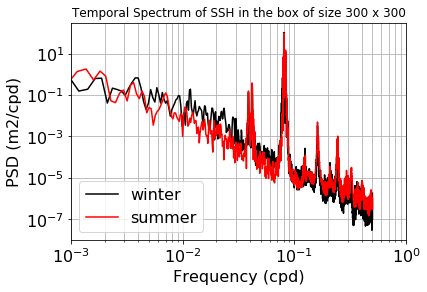

In [14]:
%time compute_plot_spectrum_ssh_reg(300) # 1x1

In [15]:
%time compute_plot_spectrum_ssh_reg(400) # 1x1

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 24632 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 28718 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 28722 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 58665 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 33323 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distr

KilledWorker: ("('rfft-rechunk-merge-d4473930aa61a479aa5f2341b1473212', 0, 0, 0)", <Worker 'tcp://127.0.0.1:40569', memory: 0, processing: 1>)

distributed.nanny - WARNING - Worker process 35248 was killed by signal 15
distributed.nanny - WARNING - Restarting worker


CPU times: user 45.7 s, sys: 27.7 s, total: 1min 13s
Wall time: 6min 22s


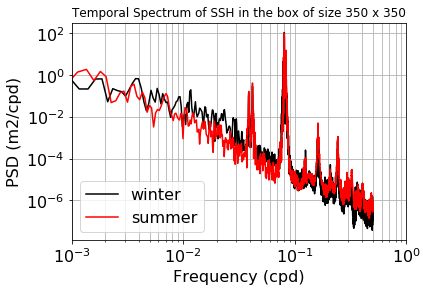

In [16]:
%time compute_plot_spectrum_ssh_reg(350) # 1x1

CPU times: user 34.8 s, sys: 25.9 s, total: 1min
Wall time: 3min 10s


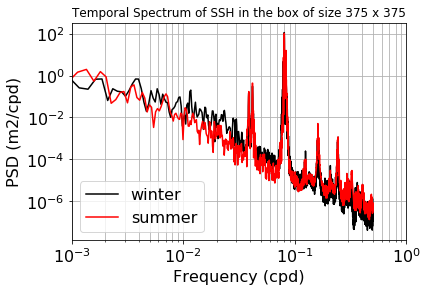

In [17]:
%time compute_plot_spectrum_ssh_reg(375) # 1x1

In [18]:
%time compute_plot_spectrum_ssh_reg(400) # 1x1

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 35252 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 47420 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 58679 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 28725 was killed by signal 15
distributed.nanny - WARNING - Restarting worker


KilledWorker: ("('rfft-rechunk-merge-2ea035689c8a23b612d70d7da7975a5b', 0, 0, 0)", <Worker 'tcp://127.0.0.1:40867', memory: 0, processing: 1>)

In [19]:
%time compute_plot_spectrum_ssh_reg_dask(400,400) # 1x1

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 48312 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 65003 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 58675 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 54646 was killed by signal 15
distributed.nanny - WARNING - Restarting worker


KilledWorker: ("('rfft-rechunk-merge-12efa2fbde87fe229fd28b11518cee9f', 0, 0, 0)", <Worker 'tcp://127.0.0.1:39813', memory: 0, processing: 1>)